# Property-Guided CO₂ Carbanion Generation Workflow

This notebook provides a reproducible workflow for:
1. Training a Chemprop property predictor (N, sN parameters)
2. Running property-guided finetuning with carbanion constraints
3. Analyzing and classifying generated molecules

**Date**: 2025-11-28  
**Environment**: pgco2

## Requirements

Before running this notebook, ensure you have:
1. Activated the `pgco2` conda environment
2. Cloned this repository and navigated to the root directory
3. Downloaded the pretrained ChEMBL model (see README.md)

## Setup and Imports

In [1]:
import os
import sys
import subprocess
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Get the current working directory (where the notebook is located)
base_dir = Path.cwd()
print(f"Working directory: {base_dir}")
print(f"Repository: {base_dir.name}")

# Check required files
required_files = [
    'generate_solvent_features.py',
    'finetune_generator_carbanion_hybrid.py',
    'postprocess_and_classify_generated.py',
    'data/mayr_nucleophiles.csv',
    'data/seed_carbanions.smi',
    'data/chembl_vocab.txt'
]

print("\nChecking required files:")
all_present = True
for file in required_files:
    exists = (base_dir / file).exists()
    status = "✓" if exists else "✗"
    print(f"{status} {file}")
    if not exists:
        all_present = False

if all_present:
    print("\n✅ All required files found!")
else:
    print("\n⚠️  Some required files are missing. Please ensure you're running this notebook")
    print("   from the prop_guided_co2_carbanion directory.")

Working directory: /home/lib33/git/prop_guided_co2_carbanion
Repository: prop_guided_co2_carbanion

Checking required files:
✓ generate_solvent_features.py
✓ finetune_generator_carbanion_hybrid.py
✓ postprocess_and_classify_generated.py
✓ data/mayr_nucleophiles.csv
✓ data/seed_carbanions.smi
✓ data/chembl_vocab.txt

✅ All required files found!


## Step 1: Data Exploration

Let's explore the input data before training.

In [2]:
# Load Mayr nucleophile data
df_mayr = pd.read_csv('data/mayr_nucleophiles.csv')

print("Mayr Nucleophile Dataset")
print("=" * 50)
print(f"Total molecules: {len(df_mayr):,}")
print(f"\nColumns: {list(df_mayr.columns)}")
print(f"\nFirst 5 rows:")
display(df_mayr.head())

# Summary statistics
print("\nSummary Statistics:")
print(df_mayr[['N', 'sN']].describe())

Mayr Nucleophile Dataset
Total molecules: 1,039

Columns: ['Smiles', 'Solvent', 'N', 'sN', 'smiles']

First 5 rows:


,Smiles,Solvent,N,sN,smiles
0,CC1=CC=CC=C1,dichloromethane,-4.36,1.77,CC1=CC=CC=C1
1,CN(C)C(=S)[S-],MeCN,20.93,0.69,CN(C)C(=S)[S-]
2,CC1=CC(C)=CC=C1,dichloromethane,-3.57,2.08,CC1=CC(C)=CC=C1
3,CC=Cc1ccccc1,dichloromethane,-0.49,1.18,CC=Cc1ccccc1
4,C=C(O[Si](C)(C)C)/C=C/OC,dichloromethane,8.57,0.84,C=C(O[Si](C)(C)C)/C=C/OC



Summary Statistics:
                 N           sN
count  1039.000000  1039.000000
mean     11.050096     0.770395
std       7.397304     0.194404
min      -8.800000     0.340000
25%       5.185000     0.630000
50%      11.990000     0.750000
75%      16.285000     0.900000
max      31.920000     2.080000


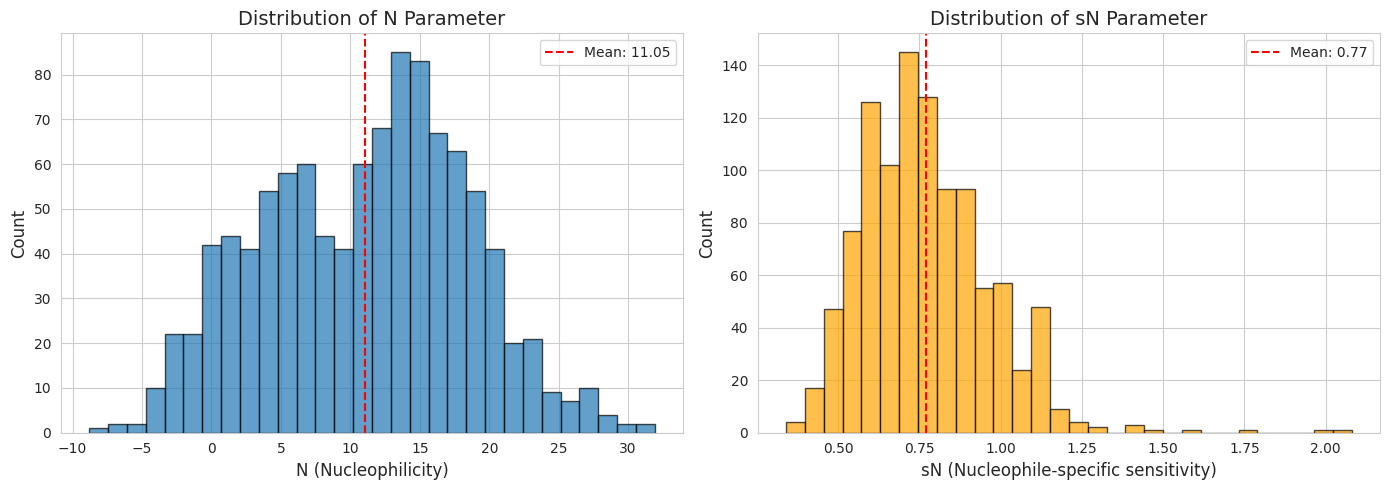

N range: [-8.80, 31.92]
sN range: [0.34, 2.08]


In [3]:
# Visualize N and sN distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# N parameter distribution
axes[0].hist(df_mayr['N'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('N (Nucleophilicity)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of N Parameter', fontsize=14)
axes[0].axvline(df_mayr['N'].mean(), color='red', linestyle='--', label=f'Mean: {df_mayr["N"].mean():.2f}')
axes[0].legend()

# sN parameter distribution
axes[1].hist(df_mayr['sN'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('sN (Nucleophile-specific sensitivity)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of sN Parameter', fontsize=14)
axes[1].axvline(df_mayr['sN'].mean(), color='red', linestyle='--', label=f'Mean: {df_mayr["sN"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"N range: [{df_mayr['N'].min():.2f}, {df_mayr['N'].max():.2f}]")
print(f"sN range: [{df_mayr['sN'].min():.2f}, {df_mayr['sN'].max():.2f}]")

In [4]:
# Check seed carbanions
with open('data/seed_carbanions.smi', 'r') as f:
    seed_smiles = [line.strip() for line in f if line.strip()]

print(f"Seed Carbanions: {len(seed_smiles)} molecules")
print("\nFirst 10 seed molecules:")
for i, smi in enumerate(seed_smiles[:10], 1):
    print(f"{i:2d}. {smi}")

Seed Carbanions: 120 molecules

First 10 seed molecules:
 1. C[CH-][N+]([O-])=O
 2. [C-]#N
 3. CC([C-](C)C(C)=O)=O
 4. O=[N+]([CH-]C)[O-]
 5. CC([CH-]C(C)=O)=O
 6. [CH2-][N+]([O-])=O
 7. CC(CC([CH-]1)=O)(C)CC1=O
 8. N#C[CH-]C#N
 9. O=S([CH-]C1=CC=C([N+]([O-])=O)C=C1)(C2=CC=CC=C2)=O
10. O=S([CH-]C1=CC=C(C#N)C=C1)(C(F)(F)F)=O


## Step 2: Generate Solvent Features

Generate 24-dimensional solvent feature vectors for the training data.

In [5]:
print("Generating solvent features...")
print("=" * 80)

cmd = [
    'python', 'generate_solvent_features.py',
    '--data_csv', './data/mayr_nucleophiles.csv',
    '--out_csv', './data/solvent_features.csv'
]

result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
else:
    print("✓ Solvent features generated successfully")
    
    # Load and inspect solvent features
    df_features = pd.read_csv('./data/solvent_features.csv')
    print(f"\nSolvent features shape: {df_features.shape}")
    print(f"Feature columns: {[c for c in df_features.columns if c.startswith('solv_')]}")

Generating solvent features...
Loaded 1039 molecules
Solvents: ['dichloromethane' 'MeCN' 'THF' 'iPrOH' 'DMSO' 'water' 'nPrOH-MeCN mix'
 'TFE' 'EtOH' 'water-acetone mix' 'water-EtOH mix' 'EtOH-MeCN mix'
 'MeOH-MeCN mix' 'water-HFIP mix' 'water-MeCN mix' 'MeOH' 'iPrOH-MeCN mix'
 'water-TFE mix' 'DMF' 'nPrOH' 'acetone' 'aq acetone' '1,2-dichloroethane'
 'aq MeCN' 'HFIP']
Saved solvent features to ./data/solvent_features.csv
Feature dimensions: (1039, 24)

✓ Solvent features generated successfully

Solvent features shape: (1039, 24)
Feature columns: []


## Step 3: Train Chemprop Model

Train a Chemprop model to predict N and sN parameters from SMILES + solvent features.

In [6]:
# Configuration
save_dir = './models/cp_model'
os.makedirs(save_dir, exist_ok=True)

print("Training Chemprop Model")
print("=" * 80)
print(f"Save directory: {save_dir}")
print(f"Training data: data/mayr_nucleophiles.csv")
print(f"Target columns: N, sN")
print(f"Features: solvent features (24-dimensional)")
print(f"Epochs: 100")
print(f"Hidden size: 300")
print("\nStarting training...\n")

Training Chemprop Model
Save directory: ./models/cp_model
Training data: data/mayr_nucleophiles.csv
Target columns: N, sN
Features: solvent features (24-dimensional)
Epochs: 100
Hidden size: 300

Starting training...



In [7]:
# Training command
cmd = [
    "chemprop_train",
    "--data_path", "./data/mayr_nucleophiles.csv",
    "--dataset_type", "regression",
    "--target_columns", "N", "sN",
    "--save_dir", save_dir,
    "--smiles_columns", "smiles",
    "--epochs", "100",
    "--hidden_size", "300",
    "--ffn_hidden_size", "300",
    "--depth", "3",
    "--save_smiles_splits",
    "--seed", "42",
    "--features_path", "./data/solvent_features.csv"
]

# Run training (this will take several minutes)
result = subprocess.run(cmd, capture_output=True, text=True)

# Display output
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
else:
    print(" " + "=" * 80)
    print("✓ Training complete!")
    print("=" * 80)



✓ Training complete!


In [8]:
# Check model outputs
model_path = Path(save_dir)
print("\nModel files:")
for file in sorted(model_path.glob('*')):
    print(f"  {file.name}")

# Try to load test scores if available
test_scores_path = model_path / 'test_scores.csv'
if test_scores_path.exists():
    df_scores = pd.read_csv(test_scores_path)
    print("\nTest Set Performance:")
    display(df_scores)


Model files:
  args.json
  fold_0
  quiet.log
  test_scores.csv
  verbose.log

Test Set Performance:


,Task,Mean rmse,Standard deviation rmse,Fold 0 rmse
0,N,2.826485,0.0,2.826485
1,sN,0.121684,0.0,0.121684


## Step 4: Run Property-Guided Finetuning

Finetune the generative model with:
- Chemprop predictor for log k(CO₂)
- Regex filter for carbanion structures
- Similarity constraints to training data

In [9]:
# Finetuning configuration
finetune_config = {
    "train": "./data/seed_carbanions.smi",
    "vocab": "./data/chembl_vocab.txt",
    "generative_model": "./hgraph2graph/ckpt/chembl-pretrained/model.ckpt",
    "chemprop_model": save_dir,  # Use the model we just trained
    "save_dir": "./models/finetune_model",
    "solvent": "DMSO",
    "logk_min": -6.0,
    "logk_max": 8.0,
    "min_similarity": 0.1,
    "max_similarity": 0.5,
    "nsample": 100,
    "epoch": 10,
    "batch_size": 50,
    "lr": 1e-3,
    "seed": 42
}

# Create output directory
os.makedirs(finetune_config["save_dir"], exist_ok=True)

print("Finetuning Configuration")
print("=" * 80)
for key, value in finetune_config.items():
    print(f"{key:20s}: {value}")
print(" ⚠️  Note: This may take 10-30 minutes depending on nsample and epoch settings.")


Finetuning Configuration
train               : ./data/seed_carbanions.smi
vocab               : ./data/chembl_vocab.txt
generative_model    : ./hgraph2graph/ckpt/chembl-pretrained/model.ckpt
chemprop_model      : ./models/cp_model
save_dir            : ./models/finetune_model
solvent             : DMSO
logk_min            : -6.0
logk_max            : 8.0
min_similarity      : 0.1
max_similarity      : 0.5
nsample             : 100
epoch               : 10
batch_size          : 50
lr                  : 0.001
seed                : 42
 ⚠️  Note: This may take 10-30 minutes depending on nsample and epoch settings.


In [10]:
# Run finetuning
print(" Starting finetuning...  ")

cmd = [
    "python", "finetune_generator_carbanion_hybrid.py",
    "--train", finetune_config["train"],
    "--vocab", finetune_config["vocab"],
    "--generative_model", finetune_config["generative_model"],
    "--chemprop_model", finetune_config["chemprop_model"],
    "--save_dir", finetune_config["save_dir"],
    "--solvent", finetune_config["solvent"],
    "--logk_min", str(finetune_config["logk_min"]),
    "--logk_max", str(finetune_config["logk_max"]),
    "--min_similarity", str(finetune_config["min_similarity"]),
    "--max_similarity", str(finetune_config["max_similarity"]),
    "--nsample", str(finetune_config["nsample"]),
    "--epoch", str(finetune_config["epoch"]),
    "--batch_size", str(finetune_config["batch_size"]),
    "--lr", str(finetune_config["lr"]),
    "--seed", str(finetune_config["seed"])
]

result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
else:
    print(" " + "=" * 80)
    print("✓ Finetuning complete!")
    print("=" * 80)


 Starting finetuning...  
MONO-ANION CARBANION GENERATION WITH HYBRID APPROACH
Method: log_k predictor + regex filter
Solvent: DMSO
log_k window: [-6.0, 8.0]
Carbanion pattern: [C-], [CH-], [CH2-] (exactly 1 per molecule)
Similarity range: [0.1, 0.5]
Samples per epoch: 100
Loaded 120 carbanion seed molecules
Performing sanity check on seed molecules...
✅ All seed molecules are connected and valid
✅ Target solvent: DMSO
✅ Solvent features: 24 dimensions
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda
✅ Loaded 1 model checkpoints
Loadin

In [11]:
# Check finetuning outputs
output_dir = Path(finetune_config['save_dir'])
print("\nFinetuning output files:")

# List good_molecules files
good_files = sorted(output_dir.glob('good_molecules.*'))
print(f"\ngood_molecules.* files: {len(good_files)}")
for file in good_files[:5]:  # Show first 5
    size = file.stat().st_size / 1024  # Size in KB
    print(f"  {file.name:25s} ({size:.1f} KB)")
if len(good_files) > 5:
    print(f"  ... and {len(good_files) - 5} more")

# List new_molecules files
new_files = sorted(output_dir.glob('new_molecules.*'))
print(f"\nnew_molecules.* files: {len(new_files)}")
for file in new_files[:5]:  # Show first 5
    size = file.stat().st_size / 1024  # Size in KB
    print(f"  {file.name:25s} ({size:.1f} KB)")
if len(new_files) > 5:
    print(f"  ... and {len(new_files) - 5} more")

# List model checkpoints
model_files = sorted(output_dir.glob('model.ckpt.*'))
print(f"\nmodel.ckpt.* files: {len(model_files)}")


Finetuning output files:

good_molecules.* files: 10
  good_molecules.0          (0.0 KB)
  good_molecules.1          (0.2 KB)
  good_molecules.2          (0.7 KB)
  good_molecules.3          (1.6 KB)
  good_molecules.4          (1.7 KB)
  ... and 5 more

new_molecules.* files: 10
  new_molecules.0           (0.0 KB)
  new_molecules.1           (0.2 KB)
  new_molecules.2           (0.1 KB)
  new_molecules.3           (0.3 KB)
  new_molecules.4           (0.4 KB)
  ... and 5 more

model.ckpt.* files: 10


## Step 5: Postprocess and Classify Generated Molecules

This step:
1. Loads all epoch files
2. Deduplicates molecules (keeping highest log k)
3. Calculates SA scores and metrics
4. Classifies carbanions using CarbanionClassifier

In [12]:
print("Postprocessing and classifying generated molecules...")
print("=" * 80)

# Create results directory
os.makedirs("./results", exist_ok=True)

output_csv = "./results/finetune_unique_classified.csv"

cmd = [
    "python", "postprocess_and_classify_generated.py",
    "--input_dir", finetune_config["save_dir"],
    "--output", output_csv,
    "--save_epoch_stats"
]

result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
else:
    print(" " + "=" * 80)
    print("✓ Postprocessing complete!")
    print("=" * 80)


Postprocessing and classifying generated molecules...
LOADING EPOCH FILES
Directory: ./models/finetune_model
Pattern: good_molecules.*
Found 10 epoch files
  Epoch  0:      0 molecules | Mean log k: nan | Max log k: nan
  Epoch  1:      3 molecules | Mean log k: 2.178 | Max log k: 4.869
  Epoch  2:     12 molecules | Mean log k: 1.391 | Max log k: 3.458
  Epoch  3:     27 molecules | Mean log k: 2.322 | Max log k: 4.992
  Epoch  4:     30 molecules | Mean log k: 2.215 | Max log k: 5.708
  Epoch  5:     52 molecules | Mean log k: 1.757 | Max log k: 5.708
  Epoch  6:     48 molecules | Mean log k: 2.160 | Max log k: 5.708
  Epoch  7:     62 molecules | Mean log k: 2.744 | Max log k: 5.730
  Epoch  8:     69 molecules | Mean log k: 2.431 | Max log k: 5.708
  Epoch  9:     72 molecules | Mean log k: 2.749 | Max log k: 5.738

✅ Total molecules across all epochs: 375
✅ Unique SMILES: 171

DEDUPLICATION
Molecules before deduplication: 375
Unique SMILES: 171
Molecules after deduplication: 171


## Step 6: Analyze Results

Load and visualize the classified molecules.

In [13]:
# Load classified molecules
df_results = pd.read_csv(output_csv)

print("Classified Molecules Dataset")
print("=" * 80)
print(f"Total unique molecules: {len(df_results):,}")
print(f"Columns: {len(df_results.columns)}")
print(f"\nColumn names:")
for i, col in enumerate(df_results.columns, 1):
    print(f"{i:2d}. {col}")

print("\nFirst 5 rows:")
display(df_results.head())

Classified Molecules Dataset
Total unique molecules: 171
Columns: 28

Column names:
 1. SMILES
 2. N
 3. sN
 4. logk_CO2
 5. max_similarity
 6. epoch
 7. SA_score
 8. n_anion_sites
 9. logk_normalized
10. SA_normalized
11. combined_score
12. alpha_groups
13. n_unique_ewg
14. ewg_multiplicity
15. combination
16. substitution_degree
17. n_carbon_neighbors
18. n_aromatic_rings
19. has_Ar
20. has_CN
21. has_CO2R
22. has_COR
23. has_C=N
24. has_NO2
25. has_SO2R
26. has_X
27. has_Aliphatic
28. has_Other

First 5 rows:


,SMILES,N,sN,logk_CO2,max_similarity,epoch,SA_score,n_anion_sites,logk_normalized,SA_normalized,...,has_Ar,has_CN,has_CO2R,has_COR,has_C=N,has_NO2,has_SO2R,has_X,has_Aliphatic,has_Other
0,CCOC(=O)[CH-]c1cccc(Cl)c1,26.5048,0.5950,5.7376,1.0000,9,3.107678,1,1.000000,0.296944,...,True,False,True,False,False,False,False,True,False,False
1,COC(=O)[CH-]c1ccccc1,26.9331,0.5736,5.7302,0.6207,7,3.068272,1,0.999269,0.286638,...,True,False,True,False,False,False,False,False,False,False
2,CCOC(=O)[CH-]c1ccccc1,26.8780,0.5739,5.7078,1.0000,9,2.946080,1,0.997055,0.254681,...,True,False,True,False,False,False,False,False,False,False
3,CCS[CH-]C#N,29.1041,0.4776,5.6110,0.2759,8,5.424631,1,0.987488,0.902911,...,False,True,False,False,False,False,False,False,False,False
4,N#C[CH-]c1ccccc1,28.4044,0.4809,5.3776,0.5652,9,3.459029,1,0.964422,0.388835,...,True,True,False,False,False,False,False,False,False,False


In [14]:
# Summary statistics
print("Summary Statistics")
print("=" * 80)

stats_cols = ['N', 'sN', 'logk_CO2', 'SA_score', 'combined_score']
print(df_results[stats_cols].describe())

print(f"\nlog k range: [{df_results['logk_CO2'].min():.3f}, {df_results['logk_CO2'].max():.3f}]")
print(f"SA score range: [{df_results['SA_score'].min():.3f}, {df_results['SA_score'].max():.3f}]")

Summary Statistics
                N          sN    logk_CO2    SA_score  combined_score
count  171.000000  171.000000  171.000000  171.000000      171.000000
mean    19.274042    0.687175    2.320913    3.307640        0.313091
std      3.936205    0.103437    1.817533    0.653732        0.244652
min      7.763900    0.434500   -4.380900    1.972292       -0.676341
25%     16.599950    0.617450    1.166400    2.865077        0.186620
50%     18.689400    0.691700    2.234300    3.195223        0.322782
75%     21.513550    0.746500    3.519100    3.592133        0.486010
max     29.104100    0.963800    5.737600    5.795857        0.742374

log k range: [-4.381, 5.738]
SA score range: [1.972, 5.796]


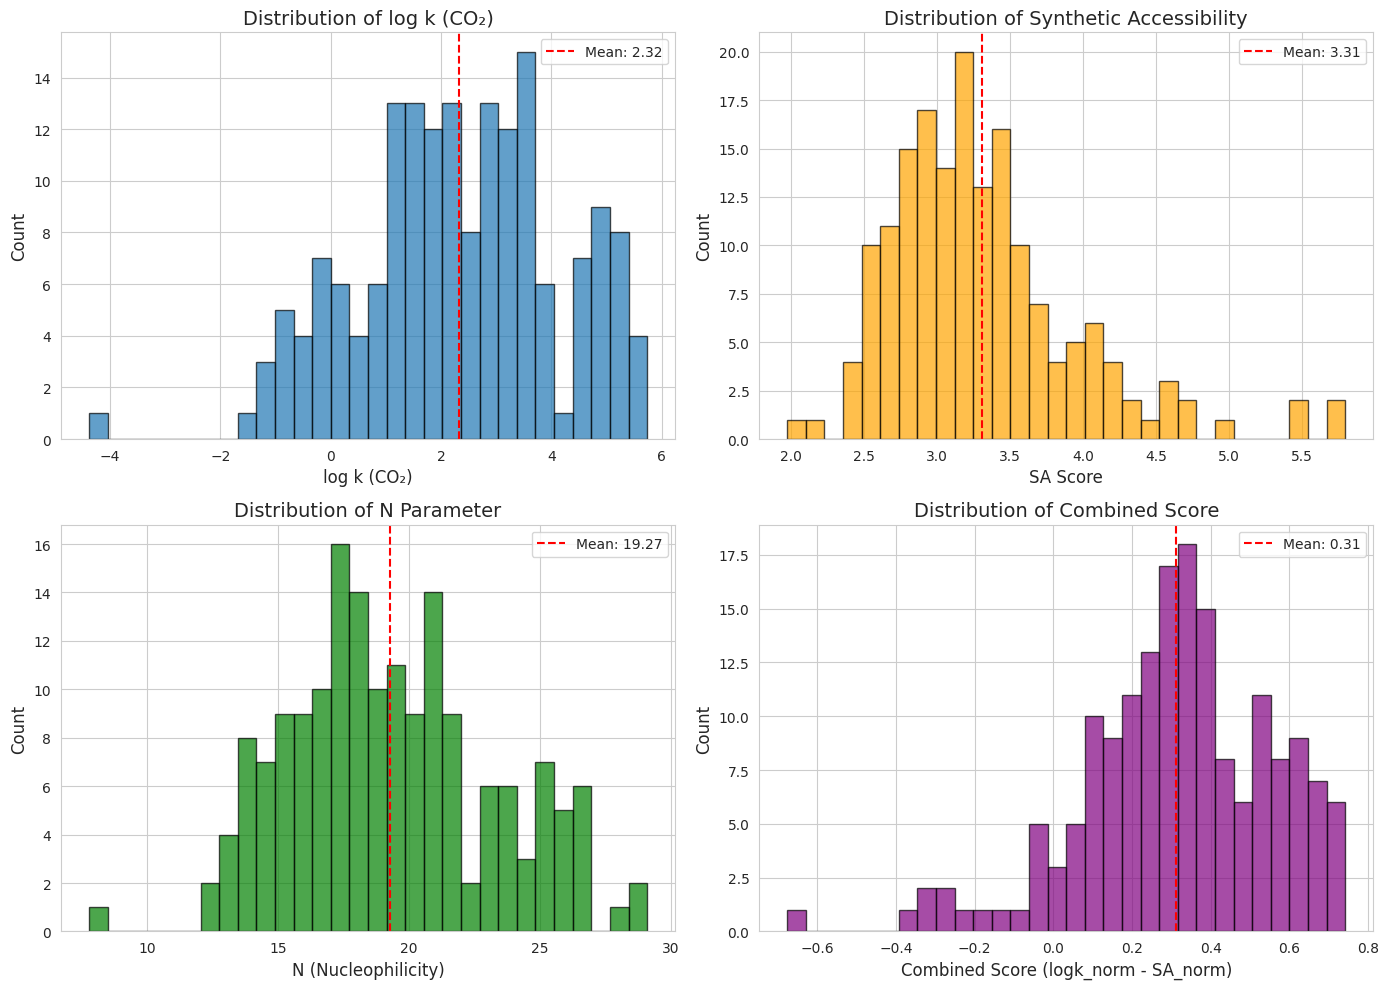

Figure saved: results_distributions.png


In [15]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# log k distribution
axes[0, 0].hist(df_results['logk_CO2'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('log k (CO₂)', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].set_title('Distribution of log k (CO₂)', fontsize=14)
axes[0, 0].axvline(df_results['logk_CO2'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_results["logk_CO2"].mean():.2f}')
axes[0, 0].legend()

# SA score distribution
axes[0, 1].hist(df_results['SA_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('SA Score', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].set_title('Distribution of Synthetic Accessibility', fontsize=14)
axes[0, 1].axvline(df_results['SA_score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_results["SA_score"].mean():.2f}')
axes[0, 1].legend()

# N parameter distribution
axes[1, 0].hist(df_results['N'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('N (Nucleophilicity)', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Distribution of N Parameter', fontsize=14)
axes[1, 0].axvline(df_results['N'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_results["N"].mean():.2f}')
axes[1, 0].legend()

# Combined score distribution
axes[1, 1].hist(df_results['combined_score'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Combined Score (logk_norm - SA_norm)', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Distribution of Combined Score', fontsize=14)
axes[1, 1].axvline(df_results['combined_score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_results["combined_score"].mean():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: results_distributions.png")

Alpha-Substituent Combinations
Ar + CO2R                :     23 (13.45%)
CO2R                     :     21 (12.28%)
CO2R + COR               :     18 (10.53%)
Ar + COR                 :     15 ( 8.77%)
Ar + SO2R                :     15 ( 8.77%)
COR                      :     11 ( 6.43%)
Ar                       :     11 ( 6.43%)
Ar + CN                  :     11 ( 6.43%)
Aliphatic                :      8 ( 4.68%)
Ar + C=N + NO2           :      8 ( 4.68%)
C=N + NO2                :      6 ( 3.51%)
CN                       :      4 ( 2.34%)
CN + COR                 :      3 ( 1.75%)
C=N + CO2R               :      2 ( 1.17%)
CN + SO2R                :      2 ( 1.17%)


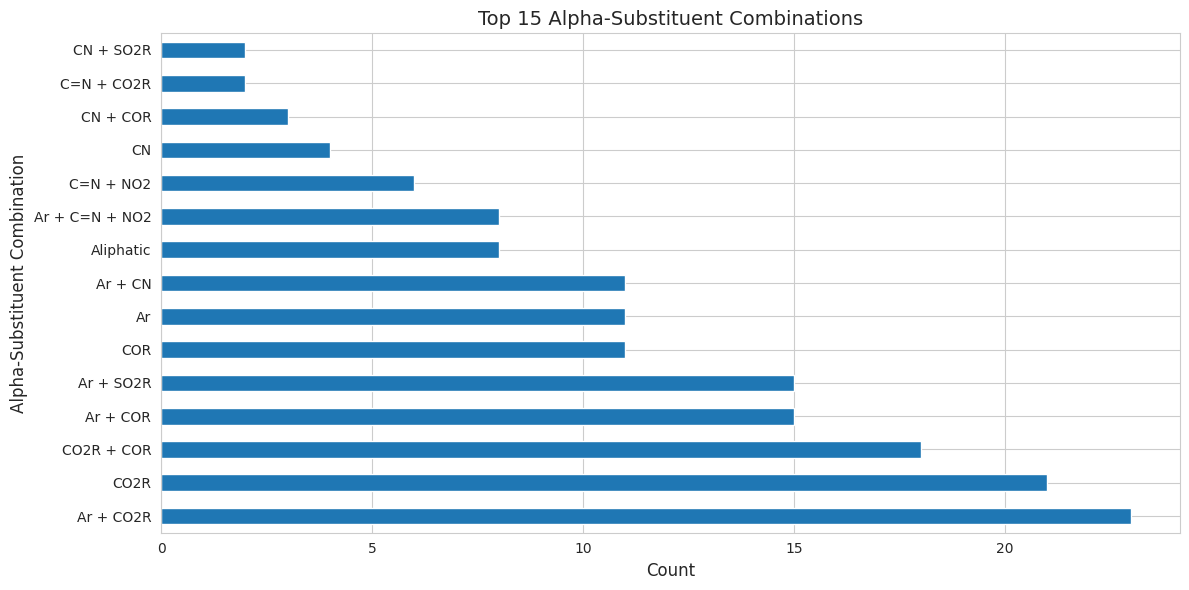


Figure saved: alpha_substituent_combinations.png


In [16]:
# Alpha-substituent combinations
print("Alpha-Substituent Combinations")
print("=" * 80)

combo_counts = df_results['combination'].value_counts().head(15)
for combo, count in combo_counts.items():
    pct = count / len(df_results) * 100
    print(f"{combo:25s}: {count:6,} ({pct:5.2f}%)")

# Visualize top combinations
plt.figure(figsize=(12, 6))
combo_counts.plot(kind='barh')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Alpha-Substituent Combination', fontsize=12)
plt.title('Top 15 Alpha-Substituent Combinations', fontsize=14)
plt.tight_layout()
plt.savefig('alpha_substituent_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved: alpha_substituent_combinations.png")

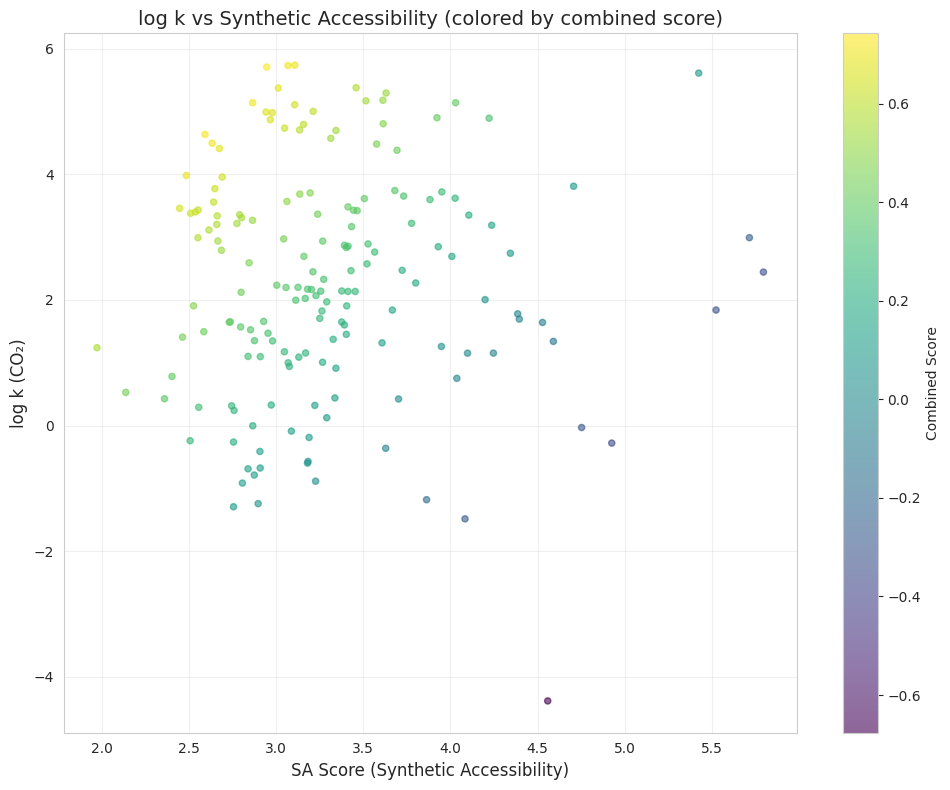

Figure saved: logk_vs_sa.png


In [17]:
# Scatter plot: log k vs SA score
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_results['SA_score'], df_results['logk_CO2'], 
                     c=df_results['combined_score'], cmap='viridis', 
                     alpha=0.6, s=20)
plt.colorbar(scatter, label='Combined Score')
plt.xlabel('SA Score (Synthetic Accessibility)', fontsize=12)
plt.ylabel('log k (CO₂)', fontsize=12)
plt.title('log k vs Synthetic Accessibility (colored by combined score)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logk_vs_sa.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: logk_vs_sa.png")

## Step 7: Export Top Candidates

Export the top 50 candidates ranked by combined score and log k(CO₂) for further analysis.

In [19]:
# Export top 50 by combined score
print("Top 50 Candidates by Combined Score")
print("=" * 80)

top50_combined = df_results.nlargest(50, "combined_score")

# Save to CSV in results directory
top50_combined.to_csv("./results/top50_by_combined_score.csv", index=False)
print(f"✅ Saved top 50 by combined score: ./results/top50_by_combined_score.csv")
print(f"   50 molecules × {len(top50_combined.columns)} columns ")

# Display summary
print("Summary of Top 50 (Combined Score):")
print(f"  Combined score range: [{top50_combined['combined_score'].min():.3f}, {top50_combined['combined_score'].max():.3f}]")
print(f"  log k range:          [{top50_combined['logk_CO2'].min():.3f}, {top50_combined['logk_CO2'].max():.3f}]")
print(f"  SA score range:       [{top50_combined['SA_score'].min():.3f}, {top50_combined['SA_score'].max():.3f}]")
print(f"  N range:              [{top50_combined['N'].min():.2f}, {top50_combined['N'].max():.2f}]")

print(" Top 10 molecules:")
display(top50_combined[["SMILES", "logk_CO2", "SA_score", "combined_score", "combination"]].head(10))


Top 50 Candidates by Combined Score
✅ Saved top 50 by combined score: ./results/top50_by_combined_score.csv
   50 molecules × 28 columns 
Summary of Top 50 (Combined Score):
  Combined score range: [0.444, 0.742]
  log k range:          [1.240, 5.738]
  SA score range:       [1.972, 3.631]
  N range:              [17.29, 28.40]
 Top 10 molecules:


,SMILES,logk_CO2,SA_score,combined_score,combination
2,CCOC(=O)[CH-]c1ccccc1,5.7078,2.946080,0.742374,Ar + CO2R
23,CCOC(=O)[CH-]N=C(c1ccccc1)c1ccccc1,4.6356,2.592141,0.728978,C=N + CO2R
1,COC(=O)[CH-]c1ccccc1,5.7302,3.068272,0.712630,Ar + CO2R
10,CCOC(=O)[CH-]c1ccc(OC)cc1,5.1388,2.865380,0.707247,Ar + CO2R
25,CC(C)(C)OC(=O)[CH-]N=C(c1ccccc1)c1ccccc1,4.4952,2.632945,0.704431,C=N + CO2R
0,CCOC(=O)[CH-]c1cccc(Cl)c1,5.7376,3.107678,0.703056,Ar + CO2R
29,O=C([CH-]c1ccccc1)Cc1ccccc1,3.9810,2.484808,0.692356,Ar + COR
5,CCOC(=O)[CH-]c1ccc(Cl)cc1,5.3731,3.012840,0.691836,Ar + CO2R
27,N#C[CH-]N=C(c1ccccc1)c1ccccc1,4.4113,2.674575,0.685251,C=N + CN
13,CCOC(=O)[CH-]c1ccc(CC)cc1,4.9916,2.942109,0.672632,Ar + CO2R


In [21]:
# Export top 50 by log k(CO₂)
print(" Top 50 Candidates by log k(CO₂)")
print("=" * 80)

top50_logk = df_results.nlargest(50, "logk_CO2")

# Save to CSV in results directory
top50_logk.to_csv("./results/top50_by_logk_CO2.csv", index=False)
print(f"✅ Saved top 50 by log k(CO₂): ./results/top50_by_logk_CO2.csv")
print(f"   50 molecules × {len(top50_logk.columns)} columns ")

# Display summary
print("Summary of Top 50 (log k):")
print(f"  log k range:          [{top50_logk['logk_CO2'].min():.3f}, {top50_logk['logk_CO2'].max():.3f}]")
print(f"  Combined score range: [{top50_logk['combined_score'].min():.3f}, {top50_logk['combined_score'].max():.3f}]")
print(f"  SA score range:       [{top50_logk['SA_score'].min():.3f}, {top50_logk['SA_score'].max():.3f}]")
print(f"  N range:              [{top50_logk['N'].min():.2f}, {top50_logk['N'].max():.2f}]")

print(" Top 10 molecules:")
display(top50_logk[["SMILES", "logk_CO2", "SA_score", "combined_score", "combination"]].head(10))


 Top 50 Candidates by log k(CO₂)
✅ Saved top 50 by log k(CO₂): ./results/top50_by_logk_CO2.csv
   50 molecules × 28 columns 
Summary of Top 50 (log k):
  log k range:          [3.380, 5.738]
  Combined score range: [0.085, 0.742]
  SA score range:       [2.446, 5.425]
  N range:              [20.81, 29.10]
 Top 10 molecules:


,SMILES,logk_CO2,SA_score,combined_score,combination
0,CCOC(=O)[CH-]c1cccc(Cl)c1,5.7376,3.107678,0.703056,Ar + CO2R
1,COC(=O)[CH-]c1ccccc1,5.7302,3.068272,0.712630,Ar + CO2R
2,CCOC(=O)[CH-]c1ccccc1,5.7078,2.946080,0.742374,Ar + CO2R
3,CCS[CH-]C#N,5.6110,5.424631,0.084577,CN
4,N#C[CH-]c1ccccc1,5.3776,3.459029,0.575586,Ar + CN
5,CCOC(=O)[CH-]c1ccc(Cl)cc1,5.3731,3.012840,0.691836,Ar + CO2R
6,CCC[CH-]C(=O)OCC,5.2935,3.630938,0.522314,CO2R
7,CCOC(=O)[CH-]C(C)C,5.1788,3.613099,0.515644,CO2R
8,C[C-](C#N)c1ccccc1,5.1692,3.515345,0.540262,Ar + CN
9,CCOC(=O)[CH-]C(C)CC,5.1390,4.030210,0.402621,CO2R
